# ShapeRx - Medical Shape Classification

The plan 
```
 - [x] download a subset of the labeled vertebrae (see below)
 - [x] create (small) 2d images from many perspectives based on those 3d models (.stl)
 - [x] extract labels from filenames
 - [x] settle on a metric 
 - [ ] train a naive classifier (histogram-based)
    - finish testing histogram utility methods 
    - build the method to average the histograms for classess and record
    - write the chi-squared comparator to find the least-different class from the provide image's histogram
 - [ ] write an accuracy checker
 - [ ] train an SVM to classify 
 - [ ] train a nn-based model to classify based on aforementioned labels 
 - [ ] write an abstraction for the three methods to enforce the common interface
 - [ ] migrate logic out of app and into python functions in separate files with a CLI front-end to experiment with ... the GUI is too slow, this should be the pattern for other projects
 - [ ] check accuracy, etc
 - [ ] tune hyperparameters
 - [ ] repeat with larger image size and more images until we are satisfied or run out of time 
 - [ ] host streamlit, textual or gradio app that serves the model someplace
 - [ ] profit
 ```

## Experimentation

### Dataset Exploration and Validation

#### Downloading

See the MSN Streamlit site for individual downloads:  https://medshapenet-ikim.streamlit.app/Download

❗ The dataset has been narrowed to vertebrae (./data/MedShapeNetDataset_vertebrae.txt) and labeled vertebrae (./data/MedShapeNetDataset_vertebrae_labeled.txt). You can fetch all (probably many gigs) with: 

```
wget --content-disposition --trust-server-names -i MedShapeNetDataset_vertebrae_labeled.txt
```

Though we probably only need a small fraction as we can generate arbitrary views with the below open3d helper functions. That is: 
1. import
2. rotate
3. save to PNG at desired size
4. repeat

This will give us as many images at whatever size we want. 

Note: Labels need to be extracted from the filenames. 

#### Sample File

In [2]:

file7 = 'data/001313_vertebraeC1.stl'

#### Loading and Visualizing the STL File

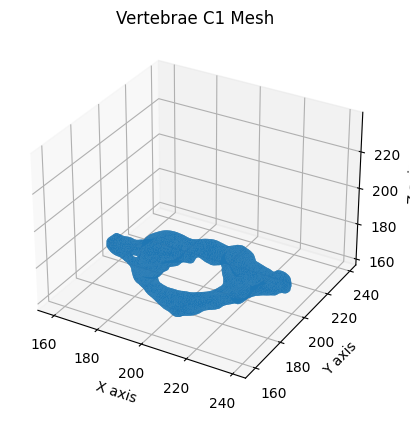

In [3]:
import numpy as np
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot

# Create a new plot
figure = pyplot.figure()
axes = figure.add_subplot(111, projection='3d')

# Load the STL file
my_mesh = mesh.Mesh.from_file(file7)

# Add the vectors to the plot
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(my_mesh.vectors))

# Auto scale to the mesh size
scale = my_mesh.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)

# Set labels and title
axes.set_xlabel('X axis')
axes.set_ylabel('Y axis')
axes.set_zlabel('Z axis')
axes.set_title('Vertebrae C1 Mesh')

# Plot
pyplot.show()

In [4]:
import vtk

def render_stl_with_lighting(stl_file, output_image, rotation):
    # Read the STL file
    reader = vtk.vtkSTLReader()
    reader.SetFileName(stl_file)
    reader.Update()

    # Create a mapper
    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputConnection(reader.GetOutputPort())

    # Create an actor
    actor = vtk.vtkActor()
    actor.SetMapper(mapper)

    # Setting actor properties
    actor.GetProperty().SetColor(0.9, 0.9, 0.9)  # Light gray color
    actor.GetProperty().SetSpecular(0.5)
    actor.GetProperty().SetSpecularPower(20)

    # Rotate object
    actor.RotateX(rotation[0])
    actor.RotateY(rotation[1])
    actor.RotateZ(rotation[2])

    # Create renderer
    renderer = vtk.vtkRenderer()
    renderer.AddActor(actor)
    renderer.SetBackground(0.5, 0.5, 0.5)  # Grey

    # Add lighting
    light = vtk.vtkLight()
    light.SetPosition(1, 1, 1) 
    light.SetFocalPoint(0, 0, 0)  
    light.SetColor(1, 1, 1) 
    light.SetIntensity(1.0)
    renderer.AddLight(light)

    # Create render window
    render_window = vtk.vtkRenderWindow()
    render_window.SetOffScreenRendering(1)
    render_window.AddRenderer(renderer)
    # Set Image size
    render_window.SetSize(500, 500)  

    # Render the scene
    render_window.Render()

    # Reset camera to fit the entire object
    renderer.ResetCamera()
    w2i = vtk.vtkWindowToImageFilter()
    w2i.SetInput(render_window)
    w2i.Update()
    writer = vtk.vtkPNGWriter()
    writer.SetFileName(output_image)
    writer.SetInputConnection(w2i.GetOutputPort())
    writer.Write()

    print(f"Image saved as {output_image}")

In [10]:
# Usage
stl_file = file7
# Set the rotations
rotations = [
    (0, 0, 0),      # Default view
    (90, 0, 0),     # Top view
    (0, 90, 0),     # Side view
    (0, 0, 90),     # Front view
    (45, 45, 0),    # Isometric view
    (30, 60, 15),   # Custom angle
]

# Render and save images for each rotation
for i, rotation in enumerate(rotations):
    output_image = f"C1/rendered_vertebrae_rotation_{i}.png"
    render_stl_with_lighting(stl_file, output_image, rotation)

Image saved as C1/rendered_vertebrae_rotation_0.png
Image saved as C1/rendered_vertebrae_rotation_1.png
Image saved as C1/rendered_vertebrae_rotation_2.png
Image saved as C1/rendered_vertebrae_rotation_3.png
Image saved as C1/rendered_vertebrae_rotation_4.png
Image saved as C1/rendered_vertebrae_rotation_5.png


### Setting up Data Directories

In [13]:
import os
import re

# Define your rotations
rotations = [
    (0, 0, 0),      # Default view
    (90, 0, 0),     # Top view
    (0, 90, 0),     # Side view
    (0, 0, 90),     # Front view
    (45, 45, 0),    # Isometric view
    (30, 60, 15),   # Custom angle
]

def process_vertebrae_files(data_dir='data'):
 
    try:
        all_files = os.listdir(data_dir)
    except FileNotFoundError:
        print(f"Data directory '{data_dir}' does not exist.")
        return

    stl_files = [f for f in all_files if f.endswith('.stl')]
    
    for filename in stl_files:
        match = re.match(r'^(\d+)_vertebrae([A-Z]\d+)\.stl$', filename)
        if not match:
            print(f"Skipping invalid filename: {filename}")
            continue
            
        file_id = match.group(1) 
        label = match.group(2)    
        label_dir = os.path.join(data_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        
        full_path = os.path.join(data_dir, filename)
        for i, rotation in enumerate(rotations):
            output_image = os.path.join(
                label_dir, 
                f"{file_id}_rendered_vertebrae_rotation_{i}.png"
            )
            render_stl_with_lighting(stl_file=full_path, output_image=output_image, rotation=rotation)

All of the stl files used to test the SVM is in my data directory. Please update to point to file location if needed.

In [ ]:
process_vertebrae_files(data_dir='data')


In [9]:
render_stl_with_lighting('data/000442_vertebraeC1.stl', 'experiments/7/000442_vertebraeC1.png', rotations)

TypeError: RotateX argument 1: must be real number, not tuple

In [6]:
import vtk
import pandas as pd
import os 

# return image, label, and filename

def generate_images2(stl_metadata, dir, size, angle):
#def render_stl_with_lighting(stl_file, output_image, rotation):

    df = pd.DataFrame(columns=['source', 'file', 'label'])
    insert_at = 0 
    examples = []
    
    # Iterate over all of the sampled files
    for row in stl_metadata.itertuples(): 
        id = row[0]
        file = row[1]
        label = row[2]    
    
        # Read the STL file
        reader = vtk.vtkSTLReader()
        
        #reader.SetFileName(stl_file)
        reader.SetFileName(os.path.join('data',file))
        reader.Update()

        # Create a mapper
        mapper = vtk.vtkPolyDataMapper()
        mapper.SetInputConnection(reader.GetOutputPort())

        # Create an actor
        actor = vtk.vtkActor()
        actor.SetMapper(mapper)

        # Setting actor properties
        actor.GetProperty().SetColor(0.9, 0.9, 0.9)  # Light gray color
        actor.GetProperty().SetSpecular(0.5)
        actor.GetProperty().SetSpecularPower(20)

        X = range(0, 360, angle)
        Y = range(0, 360, angle)
        Z = range(0, 360, angle)
        for x in X: 
            for y in Y: 
                for z in Z: 
                    # Rotate object
                    # actor.RotateX(rotation[0])
                    # actor.RotateY(rotation[1])
                    # actor.RotateZ(rotation[2])
                    actor.RotateX(x)
                    actor.RotateY(y)
                    actor.RotateZ(z)

                    # Create renderer
                    renderer = vtk.vtkRenderer()
                    renderer.AddActor(actor)
                    renderer.SetBackground(0.5, 0.5, 0.5)  # Grey

                    # Add lighting
                    light = vtk.vtkLight()
                    light.SetPosition(1, 1, 1) 
                    light.SetFocalPoint(0, 0, 0)  
                    light.SetColor(1, 1, 1) 
                    light.SetIntensity(1.0)
                    renderer.AddLight(light)

                    # Create render window
                    render_window = vtk.vtkRenderWindow()
                    render_window.AddRenderer(renderer)
                    # Set Image size
                    #render_window.SetSize(500, 500)  
                    render_window.SetSize(size, size)  

                    # Render the scene
                    render_window.Render()

                    # Reset camera to fit the entire object
                    renderer.ResetCamera()

                    # Create a window-to-image filter
                    w2i = vtk.vtkWindowToImageFilter()
                    w2i.SetInput(render_window)
                    w2i.Update()

                    # Create a PNG writer
                    writer = vtk.vtkPNGWriter()
                    #writer.SetFileName(output_image)
                    image_file = f"{id}-{label}-{size}-{x}-{y}-{z}.png"
                    path = os.path.join(dir, image_file)

                    writer.SetInputConnection(w2i.GetOutputPort())
                    writer.Write()

                    #print(f"Image saved as {output_image}")
                    print(f"Image saved as {path}")


                    # Inject the details into the dataframe we'll return 
                    # that allows follow-on processing of the generated 
                    # images
                    r = { 
                        'source': file, 
                        'file' : image_file, 
                        'label': get_class_index(label),
                        }
                    print(r)
                    df.loc[insert_at] = r
                    
                    insert_at += 1

    return df

In [ ]:
os.mkdir("experiments/7")

The syntax of the command is incorrect.


### Setting Up SVM

In [1]:
import os
print("Current working directory:", os.getcwd())
print("Files in directory:", os.listdir())
import sys
sys.path.append(r'C:\Users\santo\Documents\AIPI540\Assignment1\sganes21_classifier\shaperx\app')


Current working directory: c:\Users\santo\Documents\AIPI540\Assignment1\sganes21_classifier\shaperx
Files in directory: ['.git', '.gitignore', 'app', 'app.png', 'C1', 'data', 'experimentation.ipynb', 'Original', 'README.md', 'rendered_vertebrae_rotation_0.png', 'rendered_vertebrae_rotation_1.png', 'rendered_vertebrae_rotation_2.png', 'rendered_vertebrae_rotation_3.png', 'rendered_vertebrae_rotation_4.png', 'rendered_vertebrae_rotation_5.png', 'requirements.txt']


Categories found: ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'L1', 'L2', 'L3', 'L4', 'L5', 'T1', 'T10', 'T11', 'T12', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9']
Loading C1 images...
Loading C2 images...
Loading C3 images...
Loading C4 images...
Loading C5 images...
Loading C6 images...
Loading C7 images...
Loading L1 images...
Loading L2 images...
Loading L3 images...
Loading L4 images...
Loading L5 images...
Loading T1 images...
Loading T10 images...
Loading T11 images...
Loading T12 images...
Loading T2 images...
Loading T3 images...
Loading T4 images...
Loading T5 images...
Loading T6 images...
Loading T7 images...
Loading T8 images...
Loading T9 images...
Dataset loaded with 636 samples
Feature vector length: 250000
Number of classes: 24
Class C1: 36 samples
Class C2: 36 samples
Class C3: 36 samples
Class C4: 36 samples
Class C5: 36 samples
Class C6: 24 samples
Class C7: 24 samples
Class L1: 24 samples
Class L2: 24 samples
Class L3: 24 samples
Class L4: 24 samples
Class L5: 24

c:\Users\santo\Documents\AIPI540\Assignment1\sganes21_classifier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\santo\Documents\AIPI540\Assignment1\sganes21_classifier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\santo\Documents\AIPI540\Assignment1\sganes21_classifier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

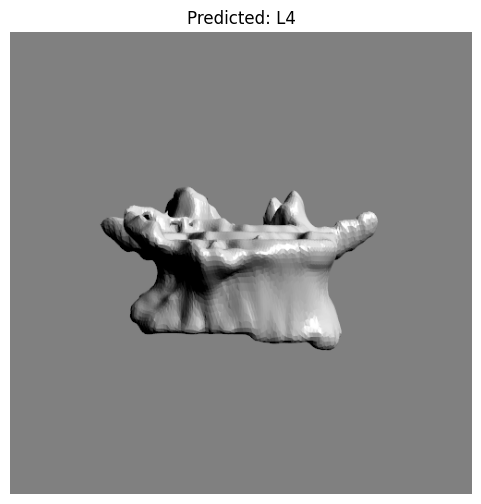


Predictions:
Image: test_image.png
Predicted class: L4
----------------------------------------


In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from svm import load_dataset, train_validate_model, predict_on_new_images


data_dir = r'C:\Users\santo\Documents\AIPI540\Assignment1\sganes21_classifier\shaperx\data'
# Reading file folders
categories = sorted([d for d in os.listdir(data_dir) 
                    if os.path.isdir(os.path.join(data_dir, d))])
print("Categories found:", categories)



X, y, filenames = load_dataset(data_dir, categories)
print(f"Dataset loaded with {len(X)} samples")
print(f"Feature vector length: {X[0].shape[0]}")
print(f"Number of classes: {len(categories)}")



# Find classes with too small samples 
unique_classes, class_counts = np.unique(y, return_counts=True)
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {categories[cls]}: {count} samples")
invalid_classes = [categories[cls] for cls, count in zip(unique_classes, class_counts) if count < 2]
if invalid_classes:
    print(f"\nERROR: Classes with insufficient samples: {invalid_classes}")


#plt.figure(figsize=(12, 6))
#for i in range(5):
#    plt.subplot(1, 5, i+1)
#    sample_img = X[i].reshape(-1, int(np.sqrt(X[i].shape[0])))  
#    plt.imshow(sample_img, cmap='gray')
#    plt.title(f"Label: {categories[y[i]]}")
#    plt.axis('off')
#plt.show()

model, scaler = train_validate_model(
    data_dir=data_dir,
    categories=categories,
    test_size=0.1,
    random_state=0,
)


new_images = [
    r'C:\Users\santo\Documents\AIPI540\Assignment1\sganes21_classifier\shaperx\Test\test_image.png',
]

predictions = predict_on_new_images(model, scaler, categories, new_images)

# Print predictions
print("\nPredictions:")
for pred in predictions:
    print(f"Image: {os.path.basename(pred['image'])}")
    print(f"Predicted class: {pred['prediction']}")
    print("-" * 40)

In [ ]:
dataset, examples = generate_images2(train_df, 'experiments/7', 32, 120)
data = generate_images2(train_df, 'experiments/7', 32, 120)

Image saved as experiments/7/3183-T5-32-0-0-0.png
{'source': '019611_vertebraeT5.stl', 'file': '3183-T5-32-0-0-0.png', 'label': 10}
Image saved as experiments/7/3183-T5-32-0-0-120.png
{'source': '019611_vertebraeT5.stl', 'file': '3183-T5-32-0-0-120.png', 'label': 10}
Image saved as experiments/7/3183-T5-32-0-0-240.png
{'source': '019611_vertebraeT5.stl', 'file': '3183-T5-32-0-0-240.png', 'label': 10}
Image saved as experiments/7/3183-T5-32-0-120-0.png
{'source': '019611_vertebraeT5.stl', 'file': '3183-T5-32-0-120-0.png', 'label': 10}
Image saved as experiments/7/3183-T5-32-0-120-120.png
{'source': '019611_vertebraeT5.stl', 'file': '3183-T5-32-0-120-120.png', 'label': 10}
Image saved as experiments/7/3183-T5-32-0-120-240.png
{'source': '019611_vertebraeT5.stl', 'file': '3183-T5-32-0-120-240.png', 'label': 10}
Image saved as experiments/7/3183-T5-32-0-240-0.png
{'source': '019611_vertebraeT5.stl', 'file': '3183-T5-32-0-240-0.png', 'label': 10}
Image saved as experiments/7/3183-T5-32-0-24

: 

In [2]:
import open3d as o3d
import copy 
import numpy as np
from open3d.visualization import rendering


def get_mesh(file): 
    if file.endswith('stl'): 
        return o3d.io.read_triangle_mesh(file)
        
def draw_mesh(mesh): 
    mesh.compute_vertex_normals()
    o3d.visualization.draw_geometries([mesh], width=192, height=108)

def rotate_mesh(mesh): 
    # https://www.open3d.org/docs/latest/tutorial/geometry/transformation.html#Rotation
    mesh_r = copy.deepcopy(mesh)
    R = mesh.get_rotation_matrix_from_xyz((np.pi / 2, 0, np.pi / 4))
    mesh_r.rotate(R, center=(0, 0, 0))

    return mesh_r

def save_image(mesh, h, w, png): 
    # https://github.com/isl-org/Open3D/issues/1095
    vis = o3d.visualization.Visualizer()
    vis.create_window(visible=False, width=w, height=h)
    vis.add_geometry(mesh)
    vis.update_geometry(mesh)
    vis.poll_events()
    vis.update_renderer()
    vis.capture_screen_image(png,do_render=True)
    vis.destroy_window()


def save_image2(mesh, png):           
    # MIT license, derived from open3d 
    #https://www.open3d.org/docs/latest/tutorial/visualization/interactive_visualization.html
    
    # TODO: fix? broken rendering method, can't get the passed mesh to show up in the view

    render = rendering.OffscreenRenderer(640, 480)

    yellow = rendering.MaterialRecord()
    yellow.base_color = [1.0, 0.75, 0.0, 1.0]
    yellow.shader = "defaultLit"

    #mesh.compute_triangle_normals()
    mesh.compute_vertex_normals()

    render.scene.add_geometry("mesh", mesh, yellow)
    render.setup_camera(60.0, [0, 0, 0], [0, 10, 0], [0, 0, 1])
    render.scene.scene.set_sun_light([0.707, 0.0, -.707], [1.0, 1.0, 1.0],75000)
    render.scene.scene.enable_sun_light(True)
    render.scene.show_axes(False)

    img = render.render_to_image()
    o3d.io.write_image(png, img, 9)
    
def save_image3(mesh, png): 

    # TODO: fix? also broken, the add geometry call isn't doing it... similar problem to save_image2

    green = rendering.MaterialRecord()
    green.base_color = [0.0, 0.5, 0.0, 1.0]
    green.shader = "defaultLit"

    w, h = 640, 480
    render = rendering.OffscreenRenderer(w, h)    

    #render.scene.add_model("mesh", mesh)
    render.scene.add_geometry("mesh", mesh, green)

    render.scene.scene.set_sun_light([-1, -1, -1], [1.0, 1.0, 1.0], 100000)
    render.scene.scene.enable_sun_light(True)
    render.scene.show_axes(False)

    aspect = h/w
    s = 3

    render.scene.camera.set_projection(rendering.Camera.Projection.Ortho,-s, s, -s*aspect, s*aspect, 0.1, 200)
    render.scene.camera.look_at([0, 0, 0], [100, 100, 100], [0, 0, 1])

    img = render.render_to_image()
    o3d.io.write_image(png, img)



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [208]:
!ls file2

13587.54s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


ls: cannot access 'file2': No such file or directory


In [ ]:
m = get_mesh(file7)

# pops a dialog, BOLO - ESC to clear
draw_mesh(m)

In [118]:
m2 = rotate_mesh(m)

# pops a dialog, BOLO - ESC to clear
draw_mesh(m2)

[Open3D WARNING] The number of points is 0 when creating axis-aligned bounding box.


In [119]:
save_image(m, h=128, w=128, png='m1.png')
save_image(m2, h=64, w=64, png='m2.png')

[Open3D WARNING] The number of points is 0 when creating axis-aligned bounding box.
[Open3D WARNING] The number of points is 0 when creating axis-aligned bounding box.


#### Visualize w/ numpy-stl

https://github.com/wolph/numpy-stl

In [120]:
import numpy as np
from stl import mesh

In [121]:
mesh2 = mesh.Mesh.from_file(file5)

FileNotFoundError: [Errno 2] No such file or directory: 'data/000007_vertebrae.stl'

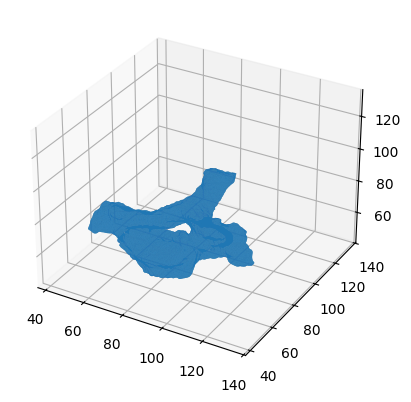

In [ ]:
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot

# Create a new plot
figure = pyplot.figure()
axes = figure.add_subplot(projection='3d')

# Add the vectors to the plot
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(mesh2.vectors))

# Auto scale to the mesh size
scale = mesh2.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)

# Show the plot to the screen
pyplot.show()

#### Visualize w/ MSN utilities

The jupyter notebook provided by the MedShapeNet dude (https://colab.research.google.com/github/Jianningli/medshapenet-feedback/blob/main/pip_install_MedShapeNetCore/getting_started.ipynb) suggest we can load and manipulate the datasets with the python library. Let's find out. 

In [30]:
from MedShapeNetCore.MedShapeNetCore import MyDict,MSNLoader,MSNVisualizer,MSNSaver,MSNTransformer

ModuleNotFoundError: No module named 'MedShapeNetCore'

In [5]:
msn_loader=MSNLoader()
msn_vis=MSNVisualizer()
msn_saver=MSNSaver()
msn_transformer=MSNTransformer()

In [6]:
data = msn_loader.load('AutoImplantCraniotomy') 

current dataset: ./medshapenetcore_npz/medshapenetcore_AutoImplantCraniotomy.npz
available keys in the dataset: ['mask']


In [8]:
volume = data['mask']
points = data['point']
#mesh_vertice = data['mesh']['vertices']
mesh_face = data['mesh']['faces']

In [11]:
# data ['mesh'] has no 'vertices' key... 
data['mesh']

MyDict([('faces', MyDict())])

In [9]:
len(volume) 

11

This is wrong?

In [29]:
#print(points.shape) -> doesn't work
#print(volume.shape) -> doesn't work
#print(points.shape) -> doesn't work
#print(mesh_vertice.shape) -> doesn't work
print(mesh_face.shape)
#print(mesh_vertice[0].shape) -> doesn't work

NameError: name 'mesh_face' is not defined

This should also work, per the notebook. 

I guess they never tested the python package with the cranial data? :(

#### Visualize w/ macOS


It turns out macOS has a native STL viewer. Just double click the file to review... 

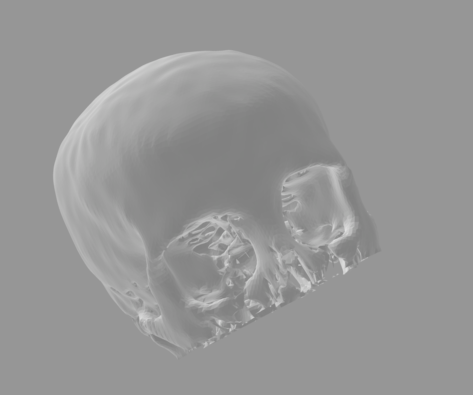

## Dataset Generation 

In [88]:
!ls experiments

1   13	17  20	24  28	31  35	39  42	46  5	53  57	8
10  14	18  21	25  29	32  36	4   43	47  50	54  58	9
11  15	19  22	26  3	33  37	40  44	48  51	55  6	notebook
12  16	2   23	27  30	34  38	41  45	49  52	56  7	train.csv


❗ Critical issue here is the lack of lighting on the rendered images, it results in all detail other than the profile of the object being lost. We need to add the camera to the rendering function (o3d research)

we need to generate some images ... but time is something we should be concerned about for this tiny run we have...
- 4 models 
- 3 axes per model
- 360/15 = 24 poses per axis

this is 4 x 24^3 = 55296 images

at least it won't be hard to hit the scale we need for transfer learning, or training a network from scratch. on the other hand, it's going to take a long time to write 55 thousand images. it took 913 minutes on my workstation - not advisable to repeat.  

⏰ the angle parameter is critical to keep low for our demonstration. image size doesn't seem to affect run time, though obviously could affect storage depending on how much we're trying to generate. suggest 45 degrees and 128 pixels (yolov8 base models all want increments of 32 so adher to that to support transfer learning option) 

at 128 pixels and 45 degree increments for 2 samples/class we have: 
 - 33 classes
 - 2 models per class
 - 360/45 = 8 orientiations per axis
  
so 33 * 2 * 8^3 = 33 * 2 * 512 = ~33K ... we might want to do a single model (15K images, 512 per class)

In [63]:
import app.dataset
import importlib
importlib.reload(app.dataset)

<module 'app.dataset' from '/home/grim/projects/school/shaperx/app/dataset.py'>

In [64]:
mesh_path = "./data"

In [65]:
meshes = app.dataset.load_mesh_metadata(mesh_path)
display(meshes.head()) 
display(len(meshes))

,filename,label
0,s0197_vertebrae_T7.nii.g_1.stl,T7
1,s0333_vertebrae_C7.nii.g_1.stl,C7
2,061481_vertebraeT7.stl,T7
3,060478_vertebraeL5.stl,L5
4,024073_vertebraeT4.stl,T4


9984

In [70]:
train_meshes = app.dataset.sample_meshes(meshes, n=1)
display(train_meshes.head())
display(len(train_meshes))

,filename,label
4489,s0210_vertebrae_T7.nii.g_1.stl,T7
1871,052826_vertebraeC7.stl,C7
5559,s0212_vertebrae_L5.nii.g_1.stl,L5
162,008738_vertebraeT4.stl,T4
7650,057333_vertebraeL3.stl,L3


24

In [69]:
experiment_path = "./experiments/notebook"
annotations_path = experiment_path + "/metadata.csv"

In [71]:
images, examples = app.dataset.generate_image_set(train_meshes, mesh_path, experiment_path, size=32, angle_increment=120)

# Our dataframe has some extra information that needs to be ejected before we 
# create the pytorch-esqe annotations file. This memorializes the splits and permits us to 
# pick up later with these labelsets.
annotations = images.drop(labels='source', axis='columns')
annotations.to_csv(annotations_path, index=False)


Image written to ./experiments/notebook/4489-T7-32-0-0-0.png
Image written to ./experiments/notebook/4489-T7-32-0-0-120.png
Image written to ./experiments/notebook/4489-T7-32-0-0-240.png
Image written to ./experiments/notebook/4489-T7-32-0-120-0.png
Image written to ./experiments/notebook/4489-T7-32-0-120-120.png
Image written to ./experiments/notebook/4489-T7-32-0-120-240.png
Image written to ./experiments/notebook/4489-T7-32-0-240-0.png
Image written to ./experiments/notebook/4489-T7-32-0-240-120.png
Image written to ./experiments/notebook/4489-T7-32-0-240-240.png
Image written to ./experiments/notebook/4489-T7-32-120-0-0.png
Image written to ./experiments/notebook/4489-T7-32-120-0-120.png
Image written to ./experiments/notebook/4489-T7-32-120-0-240.png
Image written to ./experiments/notebook/4489-T7-32-120-120-0.png
Image written to ./experiments/notebook/4489-T7-32-120-120-120.png
Image written to ./experiments/notebook/4489-T7-32-120-120-240.png
Image written to ./experiments/note

2025-05-31 10:01:20.091 (3000.510s) [    7E465D66D080]       vtkSTLReader.cxx:649    ERR| vtkSTLReader (0x1d1c94e0): STLReader: error while reading file ./data/080674_vertebraeT3.stl at line 1: Parse error. Expecting 'solid' found '7'
2025-05-31 10:01:20.092 (3000.511s) [    7E465D66D080]       vtkExecutive.cxx:729    ERR| vtkCompositeDataPipeline (0x1d2f1190): Algorithm vtkSTLReader (0x1d1c94e0) returned failure for request: vtkInformation (0x1d8416a0)
  Debug: Off
  Modified Time: 488075
  Reference Count: 1
  Registered Events: (none)
  Request: REQUEST_DATA
  FROM_OUTPUT_PORT: 0
  ALGORITHM_AFTER_FORWARD: 1
  FORWARD_DIRECTION: 0




Image written to ./experiments/notebook/8750-T3-32-0-0-240.png
Image written to ./experiments/notebook/8750-T3-32-0-120-0.png
Image written to ./experiments/notebook/8750-T3-32-0-120-120.png
Image written to ./experiments/notebook/8750-T3-32-0-120-240.png
Image written to ./experiments/notebook/8750-T3-32-0-240-0.png
Image written to ./experiments/notebook/8750-T3-32-0-240-120.png
Image written to ./experiments/notebook/8750-T3-32-0-240-240.png
Image written to ./experiments/notebook/8750-T3-32-120-0-0.png
Image written to ./experiments/notebook/8750-T3-32-120-0-120.png
Image written to ./experiments/notebook/8750-T3-32-120-0-240.png
Image written to ./experiments/notebook/8750-T3-32-120-120-0.png
Image written to ./experiments/notebook/8750-T3-32-120-120-120.png
Image written to ./experiments/notebook/8750-T3-32-120-120-240.png
Image written to ./experiments/notebook/8750-T3-32-120-240-0.png
Image written to ./experiments/notebook/8750-T3-32-120-240-120.png
Image written to ./experime

2025-05-31 10:01:27.890 (3008.309s) [    7E465D66D080]       vtkSTLReader.cxx:649    ERR| vtkSTLReader (0x1d1c94e0): STLReader: error while reading file ./data/008282_vertebraeC6.stl at line 1: Parse error. Expecting 'solid' found '0'
2025-05-31 10:01:27.890 (3008.309s) [    7E465D66D080]       vtkExecutive.cxx:729    ERR| vtkCompositeDataPipeline (0x1d2f1190): Algorithm vtkSTLReader (0x1d1c94e0) returned failure for request: vtkInformation (0x1d8416a0)
  Debug: Off
  Modified Time: 573582
  Reference Count: 1
  Registered Events: (none)
  Request: REQUEST_DATA
  FROM_OUTPUT_PORT: 0
  ALGORITHM_AFTER_FORWARD: 1
  FORWARD_DIRECTION: 0




Image written to ./experiments/notebook/6895-C6-32-0-120-0.png
Image written to ./experiments/notebook/6895-C6-32-0-120-120.png
Image written to ./experiments/notebook/6895-C6-32-0-120-240.png
Image written to ./experiments/notebook/6895-C6-32-0-240-0.png
Image written to ./experiments/notebook/6895-C6-32-0-240-120.png
Image written to ./experiments/notebook/6895-C6-32-0-240-240.png
Image written to ./experiments/notebook/6895-C6-32-120-0-0.png
Image written to ./experiments/notebook/6895-C6-32-120-0-120.png
Image written to ./experiments/notebook/6895-C6-32-120-0-240.png
Image written to ./experiments/notebook/6895-C6-32-120-120-0.png
Image written to ./experiments/notebook/6895-C6-32-120-120-120.png
Image written to ./experiments/notebook/6895-C6-32-120-120-240.png
Image written to ./experiments/notebook/6895-C6-32-120-240-0.png
Image written to ./experiments/notebook/6895-C6-32-120-240-120.png
Image written to ./experiments/notebook/6895-C6-32-120-240-240.png
Image written to ./expe

2025-05-31 10:01:34.107 (3014.526s) [    7E465D66D080]       vtkSTLReader.cxx:649    ERR| vtkSTLReader (0x1d1c94e0): STLReader: error while reading file ./data/057333_vertebraeT1.stl at line 1: Parse error. Expecting 'solid' found '.'
2025-05-31 10:01:34.107 (3014.526s) [    7E465D66D080]       vtkExecutive.cxx:729    ERR| vtkCompositeDataPipeline (0x1d2f1190): Algorithm vtkSTLReader (0x1d1c94e0) returned failure for request: vtkInformation (0x1d8416a0)
  Debug: Off
  Modified Time: 636348
  Reference Count: 1
  Registered Events: (none)
  Request: REQUEST_DATA
  FROM_OUTPUT_PORT: 0
  ALGORITHM_AFTER_FORWARD: 1
  FORWARD_DIRECTION: 0




Image written to ./experiments/notebook/10003-T1-32-0-120-0.png
Image written to ./experiments/notebook/10003-T1-32-0-120-120.png
Image written to ./experiments/notebook/10003-T1-32-0-120-240.png
Image written to ./experiments/notebook/10003-T1-32-0-240-0.png
Image written to ./experiments/notebook/10003-T1-32-0-240-120.png
Image written to ./experiments/notebook/10003-T1-32-0-240-240.png
Image written to ./experiments/notebook/10003-T1-32-120-0-0.png
Image written to ./experiments/notebook/10003-T1-32-120-0-120.png
Image written to ./experiments/notebook/10003-T1-32-120-0-240.png
Image written to ./experiments/notebook/10003-T1-32-120-120-0.png
Image written to ./experiments/notebook/10003-T1-32-120-120-120.png
Image written to ./experiments/notebook/10003-T1-32-120-120-240.png
Image written to ./experiments/notebook/10003-T1-32-120-240-0.png
Image written to ./experiments/notebook/10003-T1-32-120-240-120.png
Image written to ./experiments/notebook/10003-T1-32-120-240-240.png
Image wr

In [73]:
!echo Images in $experiment_path: 
!ls -l $experiment_path | wc -l
!echo
!echo Contents of $experiment_path: 
!ls $experiment_path


Images in ./experiments/notebook:
650

Contents of ./experiments/notebook:
10003-T1-32-0-0-0.png	     5559-L5-32-0-0-120.png
10003-T1-32-0-0-120.png      5559-L5-32-0-0-240.png
10003-T1-32-0-0-240.png      5559-L5-32-0-120-0.png
10003-T1-32-0-120-0.png      5559-L5-32-0-120-120.png
10003-T1-32-0-120-120.png    5559-L5-32-0-120-240.png
10003-T1-32-0-120-240.png    5559-L5-32-0-240-0.png
10003-T1-32-0-240-0.png      5559-L5-32-0-240-120.png
10003-T1-32-0-240-120.png    5559-L5-32-0-240-240.png
10003-T1-32-0-240-240.png    5559-L5-32-120-0-0.png
10003-T1-32-120-0-0.png      5559-L5-32-120-0-120.png
10003-T1-32-120-0-120.png    5559-L5-32-120-0-240.png
10003-T1-32-120-0-240.png    5559-L5-32-120-120-0.png
10003-T1-32-120-120-0.png    5559-L5-32-120-120-120.png
10003-T1-32-120-120-120.png  5559-L5-32-120-120-240.png
10003-T1-32-120-120-240.png  5559-L5-32-120-240-0.png
10003-T1-32-120-240-0.png    5559-L5-32-120-240-120.png
10003-T1-32-120-240-120.png  5559-L5-32-120-240-240.png
10003-T1-32

In [94]:
display(annotations.head())
display(len(annotations))

,file,label
0,4489-T7-32-0-0-0.png,11
1,4489-T7-32-0-0-120.png,11
2,4489-T7-32-0-0-240.png,11
3,4489-T7-32-0-120-0.png,11
4,4489-T7-32-0-120-120.png,11


648

## Model Training

In [116]:
experiment_path = 'experiments/21'

In [117]:
annotations = pd.read_csv(experiment_path + '/' + 'train.csv')
display(annotations.head()) 
display(len(annotations))

,file,label
0,0-T7-256-0-0-0.png,11
1,0-T7-256-0-0-45.png,11
2,0-T7-256-0-0-90.png,11
3,0-T7-256-0-0-135.png,11
4,0-T7-256-0-0-180.png,11


61440

### Naive estimator

In [ ]:
import cv2
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator 
import matplotlib.pyplot as plt

class ShapeRxEstimator(BaseEstimator): 
    """
    Interface for loading, fitting and predicting on images in our dataset. 
    This is really about enforcing semantics to ensure we can trivially 
    run cross-validation and hyperparameter search over the implementing 
    models with e.g. sklearn. 
    """
    columns = ['source', 'file', 'label']

    def fit(self, X, y=None):
        """
        Fit our estimator to some images. Note we may want to 
        pass this model into a grid search and repeatedly fit on subsets
        to identify optimal hyperparameters, so we need to handle
        reloading the training data here every time the method is called
        """
        raise NotImplementedError("Missing implementation for fit()!")

    def predict(self, X) -> np.ndarray: 
        """
        Make a prediction on a single image
        """
        raise NotImplementedError("Missing implementation for predict()!")

class NaiveEstimator(ShapeRxEstimator): 

    def __init__(self, bins=256):
        """
        Set up an instance of our naive histogram-based estimator 
        """
        self.bins = bins
        self.histograms = None
        self.labels = None

    def fit(self, X, y=None): 
        """
        Fit our naive estimator to a training set (of images)
        """
        pixel_counters = np.zeros((len(y), self.bins))
        class_counters = np.zeros((len(y)))
        
        # Tally pixels in each bin for every class, keeping track of the 
        # number of class instances we see
        for index, row in annotations.iterrows(): 
            img = self.load_image(experiment_path + "/" + row.file)    
            hist = self.histogram(img, bins=self.bins) 
            
            if row.label not in y: 
                raise ValueError("Unknown class label found!")

            pixel_counters[row.label] = pixel_counters[row.label] + hist.flatten()
            class_counters[row.label] += 1
            
            if index > 4: 
                break 

        # Compute mean 
        for label in y: 
            if class_counters[label] > 0: 
                pixel_counters[label] = pixel_counters[label] / class_counters[label]

        self.labels = y
        self.histograms = pixel_counters

    def predict(self, X) -> np.ndarray: 
        """
        Predict classes for a set of inputs (images) based on a prior fit
        """
        preds = np.zeros(len(X))
        
        for i, x in enumerate(X): 
            shortest_distance = None
            hist = self.histogram(x)

            # Apply a chi-squared distance measure to identify the closest match to our input
            for label in self.labels: 
                distance = cv2.compareHist(hist, self.histograms[label], method=cv2.HISTCMP_CHISQR)
                if shortest_distance is None or distance < shortest_distance: 
                    shortest_distance = distance
                    preds[i] = label
        
        return preds 

    def histogram(self, image:np.ndarray=None): 
        """
        Generate a histogram of the provided image

        With help from openCV docs: https://docs.opencv.org/4.x/d1/db7/tutorial_py_histogram_begins.html
        """
        hist = cv2.calcHist(images=[image], channels=[0], mask=None, histSize=[self.bins], ranges=[0,256])
        return hist

In [ ]:
naive = NaiveEstimator(bins=10)

In [ ]:
labels = annotations.label.unique()
bins=256


In [262]:
hist.shape

(256, 1)

11
11
11
11
11
11


4272.885829751189

In [ ]:
self.load_image()

### Vanilla CNN

Start with a binary classifier to get the kinks out. C6 or not C6. 

In [527]:
import torch
import torchvision 
import torchvision.transforms as transforms

In [528]:
# Look at a pytorch CNN example to understand the data format

# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

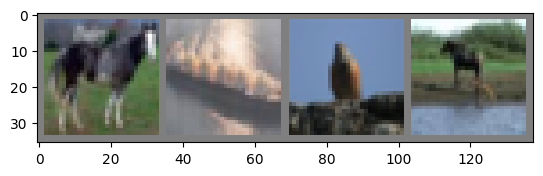

horse ship  bird  deer 


In [529]:
# And render to ensure they are loaded 

# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [530]:
batch = None
for i, b in enumerate(trainloader): 
    batch = b
    break 

In [531]:
len(batch)

2

In [532]:
# images
batch[0]

tensor([[[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],

         [[ 0.9686,  0.9686,  0.9686,  ...,  0.9686,  0.9686,  0.9686],
          [ 0.9686,  0.9686,  0.9686,  ...,  0.9686,  0.9686,  0.9686],
          [ 0.9686,  0.9686,  0.9686,  ...,  0.9686,  0.9686,  0.9686],
          ...,
          [ 0.9686,  0.9686,  0.9686,  ...,  0.9686,  0.9686,  0.9686],
          [ 0.9686,  0.9686,  0.9686,  ...,  0.9686,  0.9686,  0.9686],
          [ 0.9686,  0.9686,  0.9686,  ...,  0.9686,  0.9686,  0.9686]],

         [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  

In [533]:
# labels 
batch[1]

tensor([0, 5, 5, 7])

In [534]:
images[0].shape

torch.Size([3, 32, 32])

Inputs are 3-channel, 32-pixel square tensors. Let's convert our data to match for the test run. 

In [535]:
from PIL import Image, features

features.pilinfo()


--------------------------------------------------------------------
Pillow 11.1.0
Python 3.12.3 (main, Jan 17 2025, 18:03:48) [GCC 13.3.0]
--------------------------------------------------------------------
Python executable is /home/grim/projects/school/shaperx/venv/bin/python
Environment Python files loaded from /home/grim/projects/school/shaperx/venv
System Python files loaded from /usr
--------------------------------------------------------------------
Python Pillow modules loaded from /home/grim/projects/school/shaperx/venv/lib/python3.12/site-packages/PIL
Binary Pillow modules loaded from /home/grim/projects/school/shaperx/venv/lib/python3.12/site-packages/PIL
--------------------------------------------------------------------
--- PIL CORE support ok, compiled for 11.1.0
*** TKINTER support not installed
--- FREETYPE2 support ok, loaded 2.13.2
--- LITTLECMS2 support ok, loaded 2.16
--- WEBP support ok, loaded 1.5.0
--- JPEG support ok, compiled for libjpeg-turbo 3.1.0
--- OPE

In [536]:
!ls experiments/5

1340-T3-32-0-0-0.png	    5882-T3-32-0-0-120.png
1340-T3-32-0-0-120.png	    5882-T3-32-0-0-240.png
1340-T3-32-0-0-240.png	    5882-T3-32-0-120-0.png
1340-T3-32-0-120-0.png	    5882-T3-32-0-120-120.png
1340-T3-32-0-120-120.png    5882-T3-32-0-120-240.png
1340-T3-32-0-120-240.png    5882-T3-32-0-240-0.png
1340-T3-32-0-240-0.png	    5882-T3-32-0-240-120.png
1340-T3-32-0-240-120.png    5882-T3-32-0-240-240.png
1340-T3-32-0-240-240.png    5882-T3-32-120-0-0.png
1340-T3-32-120-0-0.png	    5882-T3-32-120-0-120.png
1340-T3-32-120-0-120.png    5882-T3-32-120-0-240.png
1340-T3-32-120-0-240.png    5882-T3-32-120-120-0.png
1340-T3-32-120-120-0.png    5882-T3-32-120-120-120.png
1340-T3-32-120-120-120.png  5882-T3-32-120-120-240.png
1340-T3-32-120-120-240.png  5882-T3-32-120-240-0.png
1340-T3-32-120-240-0.png    5882-T3-32-120-240-120.png
1340-T3-32-120-240-120.png  5882-T3-32-120-240-240.png
1340-T3-32-120-240-240.png  5882-T3-32-240-0-0.png
1340-T3-32-240-0-0.png	    5882-T3-32-240-0-120.png
1340-T

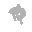

In [537]:
# PIL will accept PNGs (see above), open our image and then ues the pytorch transform to get a tensor
# We can also just call torchvision.io.read_image() ... 
img = Image.open('experiments/5/9901-C6-32-240-240-240.png')
img

In [258]:
r, g, b = img.split()

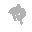

In [259]:
r

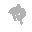

In [260]:
g

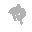

In [261]:
b

In [265]:
r.getpixel((0,0))

255

❗ we have 0-255 uint8s here it seems, make sure these are converted to floats in the range 0 - 1 during load

In [557]:
# It seems the easiest way to support these operations is by sublcassing a pytorch Dataset... urgh.
# Based on https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

class ShapeRxDataset(torch.utils.data.Dataset): 
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None): 

        # This is just a hair off the df we emit from generate_images, see above for minor transformation 
        # to achieve alignement w/ torch expectations (columns = file, label)
        self.img_labels = pd.read_csv(annotations_file)

        self.img_dir = img_dir
        self.transform = transform 
        self.target_transform = target_transform 

    def __len__(self): 
        return len(self.img_labels) 
    
    def __getitem__(self, idx): 
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        
        # This implicitly handles PNG -- wooo!
        # https://pytorch.org/vision/main/generated/torchvision.io.decode_image.html#torchvision.io.decode_image
        #image = torchvision.io.decode_image(input=img_path, mode=torchvision.io.ImageReadMode.GRAY)
        image = torchvision.io.decode_image(input=img_path)

        label = self.img_labels.iloc[idx, 1]
        if self.transform: 
            image = self.transform(image)  
        if self.target_transform: 
            label = self.target_transform(label) 
        return image, label 


In [559]:
srx_dataset.head()

,source,file,label
0,019611_vertebraeT5.stl,3183-T5-32-0-0-0.png,10
1,019611_vertebraeT5.stl,3183-T5-32-0-0-120.png,10
2,019611_vertebraeT5.stl,3183-T5-32-0-0-240.png,10
3,019611_vertebraeT5.stl,3183-T5-32-0-120-0.png,10
4,019611_vertebraeT5.stl,3183-T5-32-0-120-120.png,10


In [560]:
# write the labels to disk with pandas as a csv, they will be read by the Dataset subclass... 
# format appears to be 
#  - filename
#  - label 
# conveniently our generate function emits a df with 
#  - model file 
#  - img file
#  - label 
annotations = srx_dataset.drop(labels='source', axis='columns')
annotations.head(len(annotations))

,file,label
0,3183-T5-32-0-0-0.png,10
1,3183-T5-32-0-0-120.png,10
2,3183-T5-32-0-0-240.png,10
3,3183-T5-32-0-120-0.png,10
4,3183-T5-32-0-120-120.png,10
...,...,...
103,4619-L3-32-240-120-120.png,3
104,4619-L3-32-240-120-240.png,3
105,4619-L3-32-240-240-0.png,3
106,4619-L3-32-240-240-120.png,3


In [561]:
annotations_file = 'experiments/5/annotations.csv'
annotations.to_csv(annotations_file, index=False)

In [562]:
!cat experiments/5/annotations.csv

file,label
3183-T5-32-0-0-0.png,10
3183-T5-32-0-0-120.png,10
3183-T5-32-0-0-240.png,10
3183-T5-32-0-120-0.png,10
3183-T5-32-0-120-120.png,10
3183-T5-32-0-120-240.png,10
3183-T5-32-0-240-0.png,10
3183-T5-32-0-240-120.png,10
3183-T5-32-0-240-240.png,10
3183-T5-32-120-0-0.png,10
3183-T5-32-120-0-120.png,10
3183-T5-32-120-0-240.png,10
3183-T5-32-120-120-0.png,10
3183-T5-32-120-120-120.png,10
3183-T5-32-120-120-240.png,10
3183-T5-32-120-240-0.png,10
3183-T5-32-120-240-120.png,10
3183-T5-32-120-240-240.png,10
3183-T5-32-240-0-0.png,10
3183-T5-32-240-0-120.png,10
3183-T5-32-240-0-240.png,10
3183-T5-32-240-120-0.png,10
3183-T5-32-240-120-120.png,10
3183-T5-32-240-120-240.png,10
3183-T5-32-240-240-0.png,10
3183-T5-32-240-240-120.png,10
3183-T5-32-240-240-240.png,10
3711-C6-32-0-0-0.png,23
3711-C6-32-0-0-120.png,23
3711-C6-32-0-0-240.png,23
3711-C6-32-0-120-0.png,23
3711-C6-32-0-120-120.png,23
3711-C6-32-0-120-240.png,23
3711-C6-32-0-240-0.png,23
3711-C6-32-0-240-120.png,23
3711-C6-32-0-240-240.

In [563]:
# Our dataset class creates a uint8 tensor on load, we need to convert to float and normalize
transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float),
    ])

In [564]:
dataset = ShapeRxDataset(annotations_file, 'experiments/5', transform)

In [565]:
len(dataset)

108

In [566]:
loader = torch.utils.data.DataLoader(dataset)

In [567]:
dataiter = iter(loader)

In [568]:
image, label = next(dataiter)
image, label

(tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],
 
          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],
 
          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]]]),
 tensor([10]))

In [569]:
image.min()

tensor(0.6980)

In [570]:
image.max()

tensor(1.)

Okay, now we have a torch-compatible dataset that is emitting tensors, which are scaled and normalized by the transformation provided and that is accessible by the loader object. 

In [571]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = (img / 2 + 0.5) * 256    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

... but the iterator is returning an extra dimension for batch (). We need to squeeze() it to omit the batch dimension, then we can render it. 

In [572]:
image.numpy().shape

(1, 3, 32, 32)

In [573]:
image.squeeze().numpy().shape

(3, 32, 32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [217.34903..256.0].


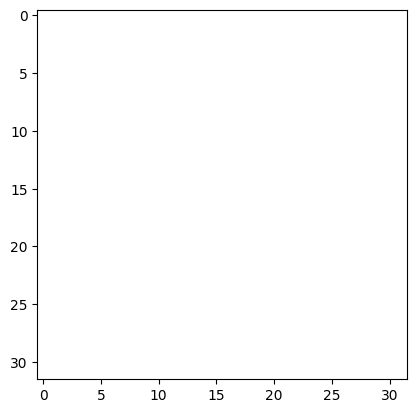

tensor([10])


In [574]:
imshow(image.squeeze())
print(label)

❗ TODO: get the above image to render to ensure we are loading correclty

In [575]:
# note the totensor operation should drive the pixel values to 0-1 float 
transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.5], std=[0.5])
    ])

In [576]:
dataset = ShapeRxDataset(annotations_file, 'experiments/5', transform=transform)
#dataset = ShapeRxDataset(annotations_file, 'experiments/5')
loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)

In [598]:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super().__init__()
        
        # in, out, kernel size
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(class_map))

    def forward(self, x):
        # 1. Convolution + pooling
        # input:       3 x 32^2 
        # conv @ 6, 5: 6 x 28^2
        # pool @ 2x2:  6 x 14^2
        x = self.pool(F.relu(self.conv1(x)))

        # 2. Convlution + pooling
        # input:       6 x 14^2 
        # conv @ 16,5: 16 x 10^2
        # pool @ 2x2:  16 x 5^2
        x = self.pool(F.relu(self.conv2(x)))

        # 3. Reshape
        # input:       16 x 5^2
        # flatten @ 1: 1 x 400
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        
        # 4. Fully-connecter
        # input:       1 x 400
        # linear:      1 x 120
        x = F.relu(self.fc1(x))
        
        # 5. Fully-connected 
        # input:       1 x 120
        # linear:      1 x 84
        x = F.relu(self.fc2(x))
            
        # 6. Fully-connected output 
        # input:       1 x 84
        # linear:      1 x 24 (vertebrae/classes)
        x = self.fc3(x)
        
        return x


net = Net()

In [583]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [584]:
type(loader)

torch.utils.data.dataloader.DataLoader

In [585]:
for i, data in enumerate(loader, 0):
    print(data[0].max(), data[0].min())
    break 

tensor(1.) tensor(0.3961)


In [588]:
# Adapted from PyTorch image classifier tutorial - https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,    20] loss: 0.016
[1,    40] loss: 0.015
[2,    20] loss: 0.015
[2,    40] loss: 0.015
Finished Training


❗ TODO: probably need to normalize our inputs here so they are floats and not 0-255... see above

In [590]:
output = net(image)

In [594]:
output

tensor([[-0.0338, -0.8743, -0.8736,  3.4067, -1.0474, -0.7770, -0.8044, -0.7456,
          3.9326, -0.8288,  3.7723, -0.7206, -0.6432, -0.2598, -0.5207, -0.9175,
         -0.9331, -1.0665, -0.7689, -0.7508, -0.7480, -1.1863, -0.9056,  3.3946]],
       grad_fn=<AddmmBackward0>)

In [595]:
# Export to ONNX format
#https://pytorch.org/tutorials/beginner/onnx/export_simple_model_to_onnx_tutorial.html

torch_input = torch.randn(1, 3, 32, 32)
onnx_program = torch.onnx.dynamo_export(net, torch_input)

/home/grim/projects/school/shaperx/venv/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/grim/projects/school/shaperx/venv/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/grim/projects/school/shaperx/venv/lib/python3.12/site-packages/torch/onnx/_internal/_exporter_legacy.py:101: UserWarning: torch.onnx.dynamo_export only implements opset version 18 for now. If you need to use a different opset version, please register them with register_custom_op.
  warnings.warn(
/home/grim/projects/school/shaperx/venv/lib/python3.12/site-packages/torch/onnx/_internal/fx/onnxfunctio

In [597]:
onnx_program.save("experiments/5/model.onnx")

Netron rendering of the network: 

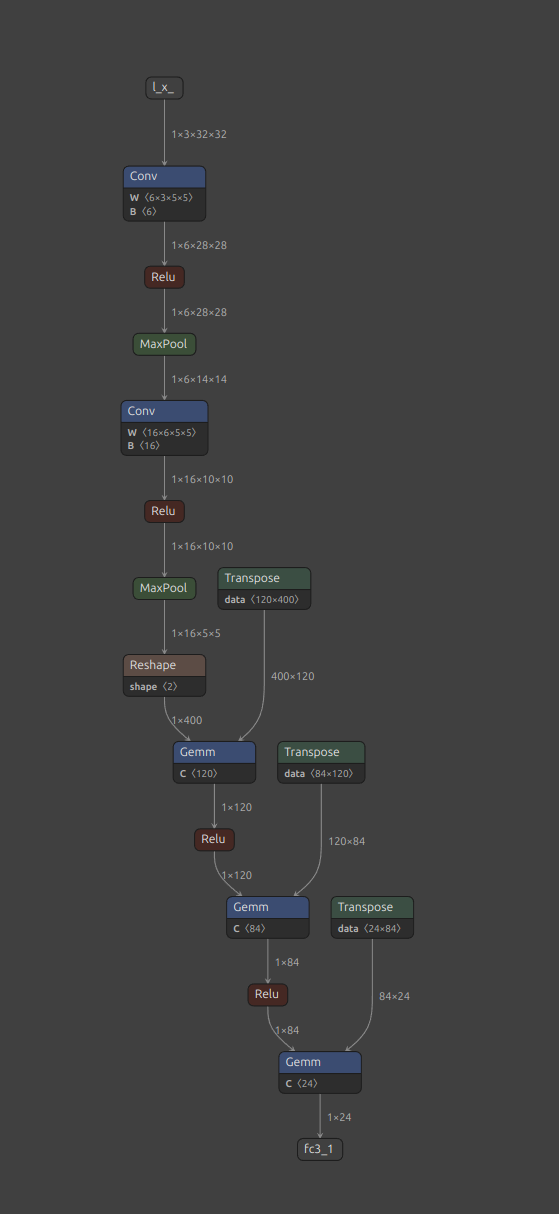

### YOLOv8 tuning

## Model Validation

## Deployment

TBD - wait to see what the computational and storage requirements are for the classification model and then use a rapid prototyping package like textual or streamlit to mock up a demo. 